In [1]:
import os
import glob
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyemma as py
import scipy
import mdtraj as md
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from scipy import stats

In [2]:
def violin_plots(file_paths, specifications, start_base, end_base, unit, step_biobb):
    
    #Variables - Choose 12 for helical parameters and 16 for torsion angles
    
    file_list = []
    list_of_lists = []
    std_list = []
    colors = ["orange", "crimson", "blue", "deepskyblue", "yellowgreen", "gold"]

    for specification in specifications:
        file_list = []
        for file in file_paths.items():
            list_new = []
            for n in range(start_base,end_base):
                f = glob.glob(f'./{file[1]}/step{step_biobb}*/timeseries/*series*_{specification}_{n}_*csv*')
                list_new.append(f[0])
            file_list.append(list_new)
        list_of_lists.append(file_list)
            
    list_of_lists = np.array(list_of_lists)
    
    fig, axes = plt.subplots(1, len(specifications), figsize=(20, 6), sharex = True)
    
    #making the labels
    labels = []
    
    for sub_list in list_of_lists:
        for label in sub_list[0]:
            for word in label.split("/"):
                if ".csv" in word:
                    if step_biobb == 16:
                        labels.append(word.split("_")[2][0:4] +
                                      word.split("_")[3][0:1])
                    else:
                        labels.append(word.split("_")[2][0:4] + 
                                      word.split("_")[3][0:2])
                
    labels = labels[0:end_base-start_base]
    
    #creating patches
    
    patch_list = []
    for item, colour in zip(file_paths.items(), colors):
        patch = mpatches.Patch(color = colour, label = item[0])
        patch_list.append(patch)

    l1 = []
    l2 = []
    l3 = []
    
    #unpacking the files
    
    for sub_list in list_of_lists:
        l2 = []
        for ss_list in sub_list:
            l3 = []
            for file in ss_list:
                df = pd.read_csv(file)
                l3.append(df.iloc[:,1])
            l2.append(l3)
        l1.append(l2)

    #making the graphs
    
    for ax, specification, bli in zip(axes, specifications, l1):
       # print(specification)
        positions = np.arange(len(bli[0]))
        i = -0.3
        for sli, color in zip(bli, colors):
            
            for ssli, position in zip (sli, positions):
                i += 0.04
                violin_parts = ssli
                ax.set_xlabel(specification)
                ax.set_xticks(np.arange(5))
                ax.set_xticklabels(labels)

                violins = ax.violinplot(ssli, positions=[position + i], 
                                        showextrema=False, showmeans=True, widths=0.2)
                
                for vp in violins['bodies']:
                    vp.set_facecolor(color)
                    vp.set_alpha(0.3)
                  
                vip = violins['cmeans']
                vip.set_edgecolor("black")
                vip.set_linewidth(1)
                    
    axes[0].legend(handles=patch_list)
    
    axes[0].set_ylabel(unit)   

In [3]:
def assemble_array(file_paths, parameters, number_of_basepairs, 
                   step_biobb, is_angle, dot_size = 8, free_energy = True, 
                   is_seperate = False, default_classification = "By_File", base_pair = 33):
    
    #Variables, dictionaries
    #if is_seperate is true, you can use a different default classification 
    colors = ["orange", "crimson", "blue", "deepskyblue", "yellowgreen", "gold"]
    
    biobb_dictionary = {
        16:"Torsions",
        12:"Helical Parameters"
    }
    
    list_of_parameters = []
    
    shape_list = []
    shape_shape_list = []
    shape_shape_shape_list = []
    
    for file in file_paths.items():
        list_of_basepairs = []
        shape_shape_list = []
        
        for param in parameters:
            list_of_values = []
            shape_list = []
            
            for n in number_of_basepairs: 
                
                f = glob.glob(f'./{file[1]}/step{step_biobb}*/timeseries/*series*_{param}_{n}_*csv*')
                df = pd.read_csv(f[0])
                df = df.drop(df.columns[[0]], axis = 1)
                values = df[:].values
                
                list_of_values.append(values)
                shape_list.append(len(values))   
                
            shape_shape_list.append(shape_list[0])
            list_of_basepairs.append(list_of_values)
            
        list_of_parameters.append(list_of_basepairs)
        shape_shape_shape_list.append(list(set(shape_shape_list))[0])
    
    #creating the array to input into the pca function
    
    shape_list = shape_shape_shape_list
    shape_list = [0, *shape_list]

    input_array = np.concatenate(list_of_parameters, axis=2)
    input_array = np.concatenate(input_array)
    input_array = np.concatenate(input_array, axis=1)

    if is_angle == True:
        
        sin_array = np.sin(input_array * np.pi / 180.)
        cos_array = np.cos(input_array * np.pi / 180.)
        plot_type = "Angles"             
        X = np.concatenate([sin_array, cos_array], axis = 1)
    else:
        
        X = input_array
        plot_type = "Distances"
    
    #creating, custommizing the PCA
    
    pca = PCA(n_components=2)
    pca.fit(X)
    X_2d = pca.transform(X)
    print(np.shape(X_2d))
    
    if free_energy == True and is_seperate == False:
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey = True, sharex =True) 
        fig.suptitle('PCA & Free Energy Plots for: ' + plot_type + "," + 
                     biobb_dictionary[step_biobb], fontsize=25)
        py.plots.plot_free_energy(X_2d[:, 0], X_2d[:, 1], ax=axes[1])
    elif free_energy == False and is_seperate == False:
        
        fig, axes = plt.subplots(1, 1, figsize=(15, 8), sharey = True, sharex =True) 
        fig.suptitle('PCA Plots for: ' + plot_type + "," + 
                     biobb_dictionary[step_biobb], fontsize=25)
    else:
        pass
    
    block_list = []
    
    #Iterating to highlight the PCA by color
    if is_seperate == False:
        for i, item, color in zip(np.arange(1,len(shape_list)),file_paths.items(), colors):

            col = shape_list[i]
            block = sum(shape_list[0:i+1])
            block_size = sum(shape_list[0:i])
            block_list.append(block)

            if free_energy == True:
                
                axes[0].scatter(X_2d[block_size:block, 0], X_2d[block_size:block, 1], 
                            alpha=0.2, color= color,
                            label =item[0], s=dot_size)
                axes[0].set_xlabel("PCA Dimension 1")
                axes[0].set_ylabel("PCA Dimension 2")
                axes[0].legend()
                
            else:
                axes.scatter(X_2d[block_size:block, 0], 
                            X_2d[block_size:block, 1], alpha=0.2, color= color,
                            label =item[0], s=dot_size)
                axes.set_xlabel("PCA Dimension 1")
                axes.set_ylabel("PCA Dimension 2")

                axes.legend()
    elif is_seperate == True and free_energy == False:
        
        fig, axes = plt.subplots(1, len(file_paths), figsize=(15, 8), sharey = True, sharex =True) 
        fig.suptitle('PCA & Free Energy Plots for: ' + plot_type + "," + 
                     biobb_dictionary[step_biobb], fontsize=25)
        
        for i, item, color, ax in zip(np.arange(1,len(shape_list)), file_paths.items(), colors, axes):

            col = shape_list[i]
            block = sum(shape_list[0:i+1])
            block_size = sum(shape_list[0:i])
            block_list.append(block)
            
            ax.scatter(X_2d[block_size:block, 0], X_2d[block_size:block, 1], alpha=0.2, color = color, 
                            label =item[0], s=dot_size)
            
            ax.set_xlabel("PCA Dimension 1")
            ax.set_ylabel("PCA Dimension 2")
            ax.legend()
    else:
        
        fig, axes = plt.subplots(2, len(file_paths), figsize=(15, 8), sharey = True, sharex =True) 
        fig.suptitle('PCA & Free Energy Plots for: ' + plot_type + "," + 
                     biobb_dictionary[step_biobb], fontsize=25)
        
        for i, item, color in zip(np.arange(1,len(shape_list)),file_paths.items(), colors):
                col = shape_list[i]
                block = sum(shape_list[0:i+1])
                block_size = sum(shape_list[0:i])
                block_list.append(block)
                if default_classification == "By_File":
                    axes[0,i-1].scatter(X_2d[block_size:block, 0], X_2d[block_size:block, 1], 
                                alpha=0.2, color = color, 
                                label =item[0], s=dot_size)
                    axes.set_xlabel("PCA Dimension 1")
                    axes.set_ylabel("PCA Dimension 2")

                elif default_classification == "By_Base_Pair":
                    axes[0,i-1].scatter(X_2d[block_size:block, 0], X_2d[block_size:block, 1], 
                                alpha=0.2, c= X[block_size:block, base_pair], 
                                label =item[0], s=dot_size)
                    axes[0,0].set_xlabel("PCA Dimension 1")
                    axes[0,0].set_ylabel("PCA Dimension 2")
                
                py.plots.plot_free_energy(X_2d[block_size:block, 0],
                                          X_2d[block_size:block, 1], ax=axes[1,i-1])
                axes[0,i-1].legend()
    

In [4]:
Filepaths_new = ['DESRES_e8_310K_Uncut', 'DESRES_e8_310K_Cut', 'wf_dna_helparms_uncut310K']

Filepaths_new = {"Deshaw Uncut - 350.8 ns" : 'DESRES_e8_310K_Uncut', 
                 "Deshaw Cut - 394 ns" : 'DESRES_e8_310K_Cut',
                 "Amber Uncut - 1000 ns" : "wf_dna_helparms_uncut310K",
                 "Amber Cut - 1000 ns":"wf_dna_helparms_cut310K"}

specification_list = ['chiW', 'deltaW', 'gammaW', 'phaseW']

specification_list = ['alphaC', 'betaC']

specification_list_distances = ['rise', 'slide', 'shift']

specification_list_angles = ['tilt', 'roll', 'twist']



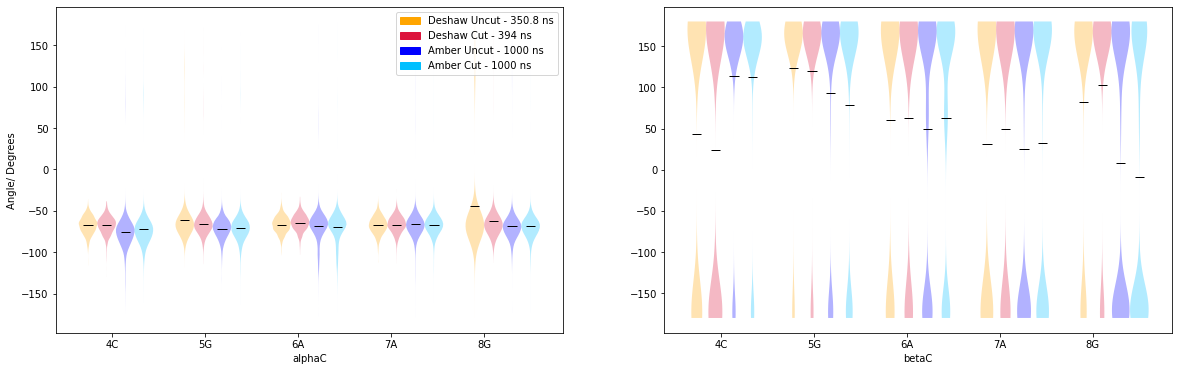

In [5]:
test = violin_plots(Filepaths_new, specification_list, 4, 9, "Angle/ Degrees", 16)

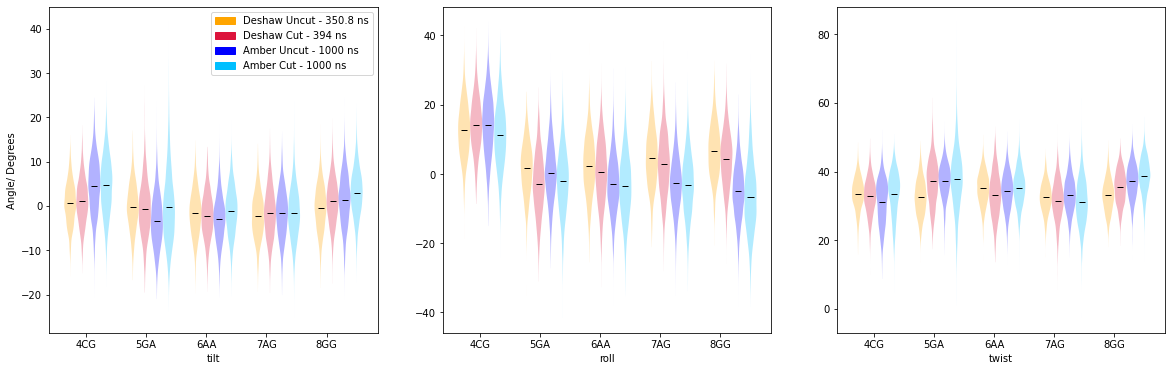

In [6]:
test = violin_plots(Filepaths_new, specification_list_angles, 4, 9, "Angle/ Degrees", 12)

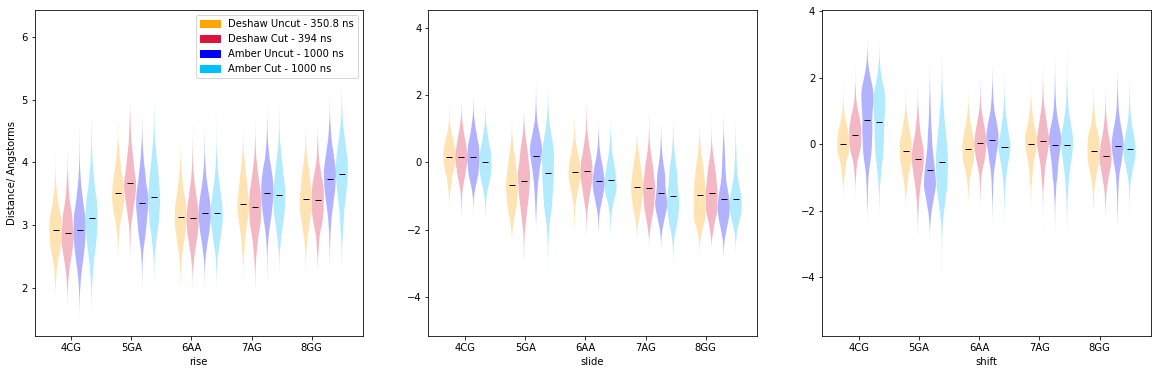

In [7]:
test = violin_plots(Filepaths_new, specification_list_distances, 4, 9, "Distance/ Angstorms", 12)

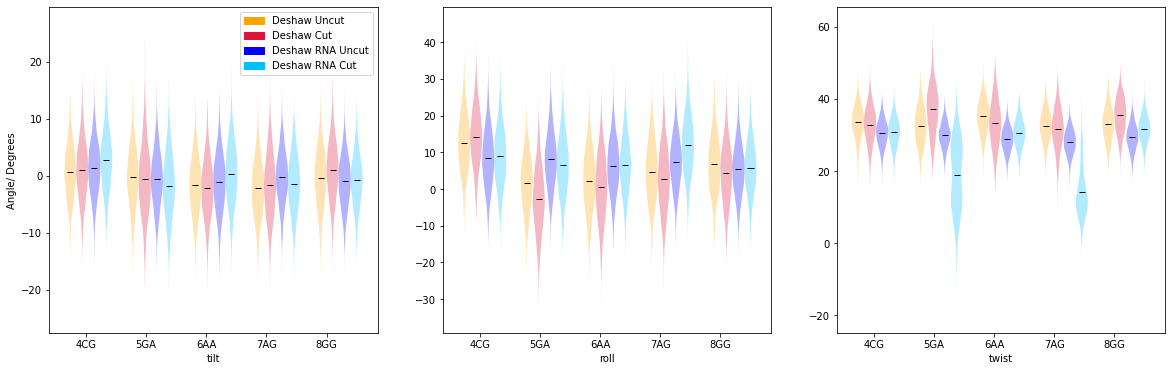

In [25]:
Filepaths_new = {"Deshaw Uncut" : 'DESRES_e8_310K_Uncut', 
                 "Deshaw Cut" : 'DESRES_e8_310K_Cut', 
                 "Deshaw RNA Uncut" : "DesRNA_e8_300K_Uncut",
                 "Deshaw RNA Cut":"DesRNA_e8_300K_cut"}

test = violin_plots(Filepaths_new, specification_list_angles, 4, 9, "Angle/ Degrees", 12)

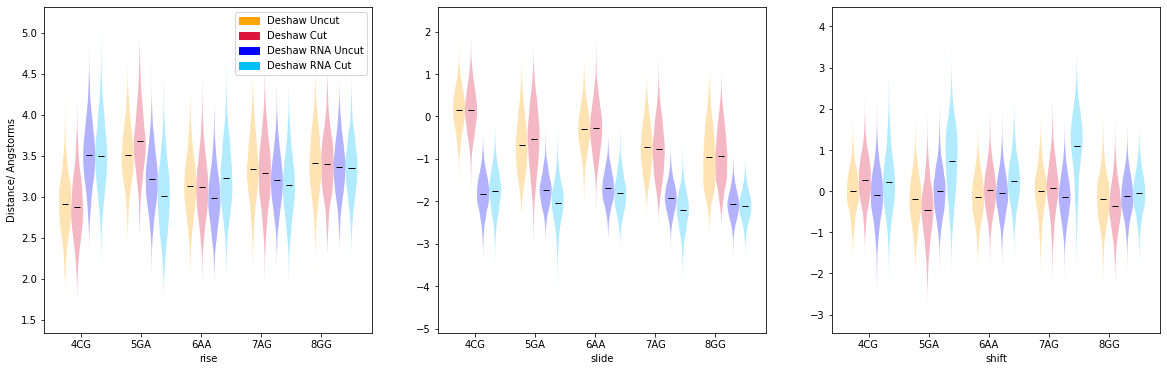

In [26]:
test = violin_plots(Filepaths_new, specification_list_distances, 4, 9, "Distance/ Angstorms", 12)

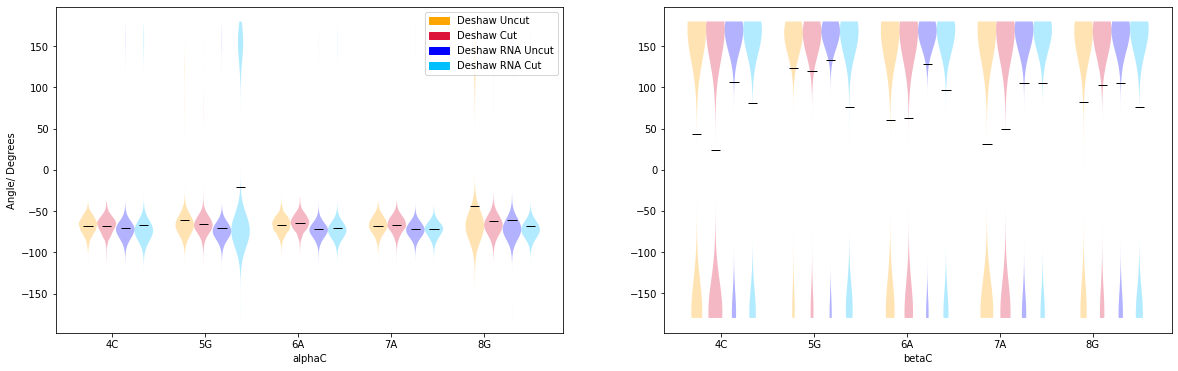

In [27]:
test = violin_plots(Filepaths_new, specification_list, 4, 9, "Angle/ Degrees", 16)

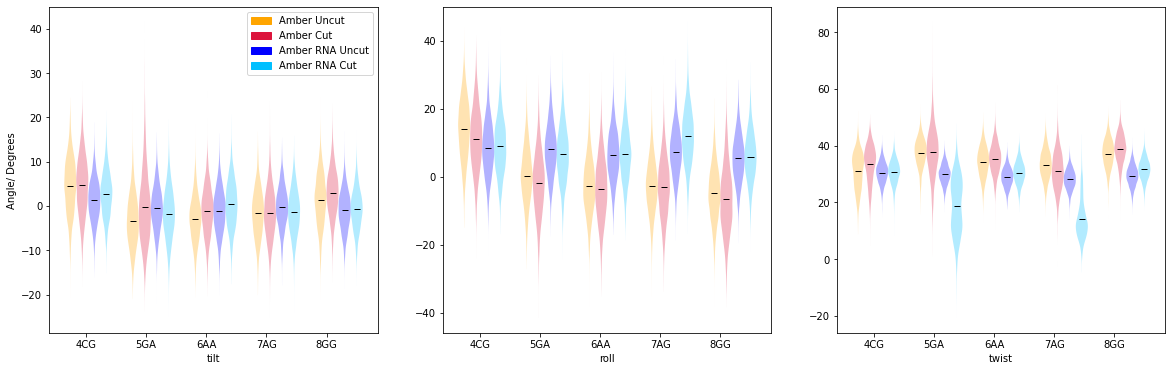

In [28]:
Filepaths_new = {"Amber Uncut" : 'wf_dna_helparms_uncut310K', "Amber Cut" : 'wf_dna_helparms_cut310K', "Amber RNA Uncut" : "DesRNA_e8_300K_Uncut", "Amber RNA Cut":"DesRNA_e8_300K_cut"}


test = violin_plots(Filepaths_new, specification_list_angles, 4, 9, "Angle/ Degrees", 12)

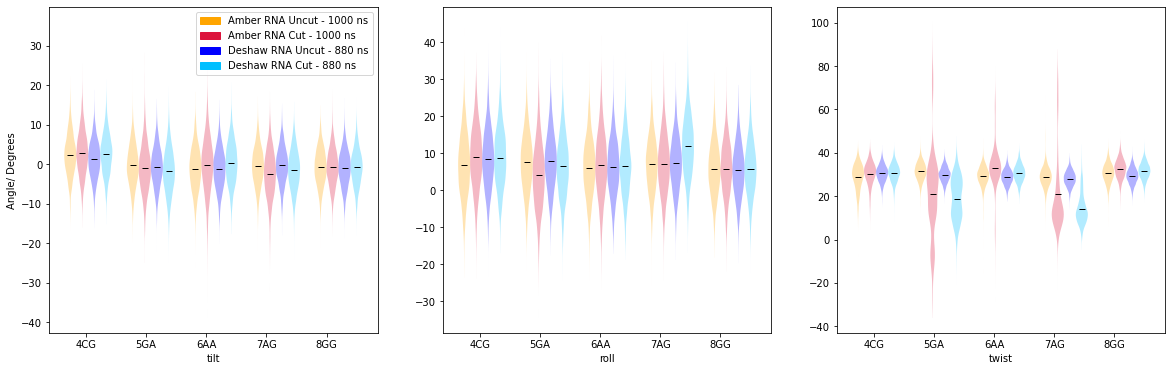

In [29]:
Filepaths_new = {"Amber RNA Uncut - 1000 ns" : 'Amber_RNA_e8_300K_uncut', "Amber RNA Cut - 1000 ns" : 'Amber_RNA_e8_300K_cut', "Deshaw RNA Uncut - 880 ns" : "DesRNA_e8_300K_Uncut", "Deshaw RNA Cut - 880 ns":"DesRNA_e8_300K_cut"}

test = violin_plots(Filepaths_new, specification_list_angles, 4, 9, "Angle/ Degrees", 12)

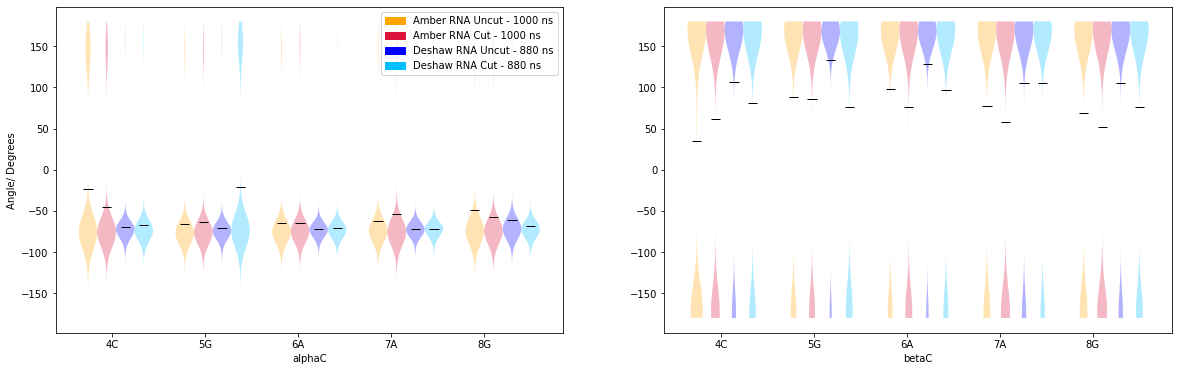

In [30]:
test = violin_plots(Filepaths_new, specification_list, 4, 9, "Angle/ Degrees", 16)

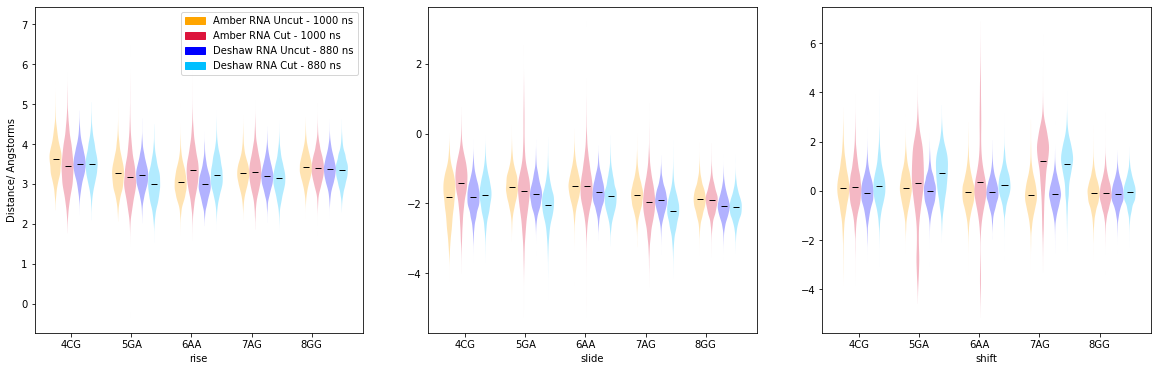

In [31]:
test = violin_plots(Filepaths_new, specification_list_distances, 4, 9, "Distance/ Angstorms", 12)


(18769, 2)


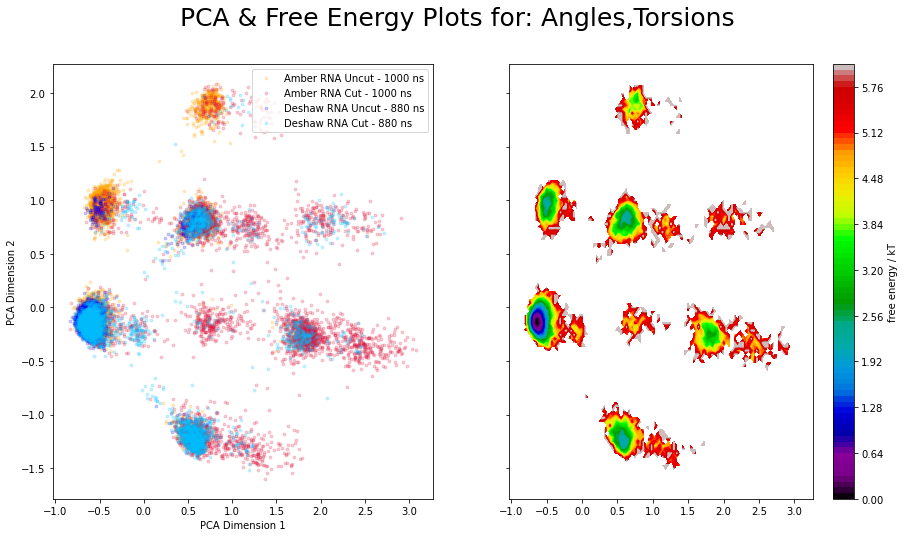

In [32]:


number_of_basepairs = np.arange(5,10)
parameters_list = ['chiW', 'deltaW', 'gammaW', 'phaseW']
# parameters_list = ['chiW']
input_array = assemble_array(Filepaths_new, parameters_list, number_of_basepairs, 16, True)

(18769, 2)


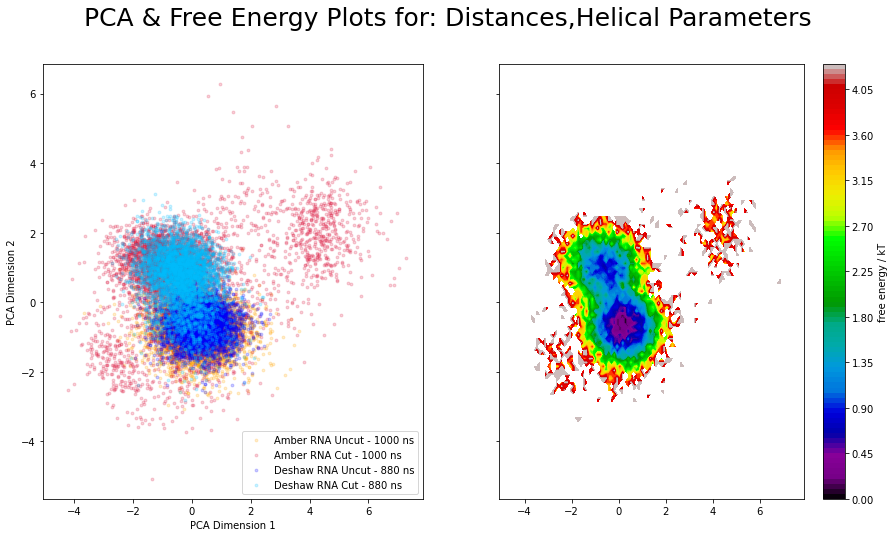

In [33]:
parameters_list = ['rise', 'slide', 'shift']
input_array = assemble_array(Filepaths_new, parameters_list, number_of_basepairs, 12, False)

(18769, 2)


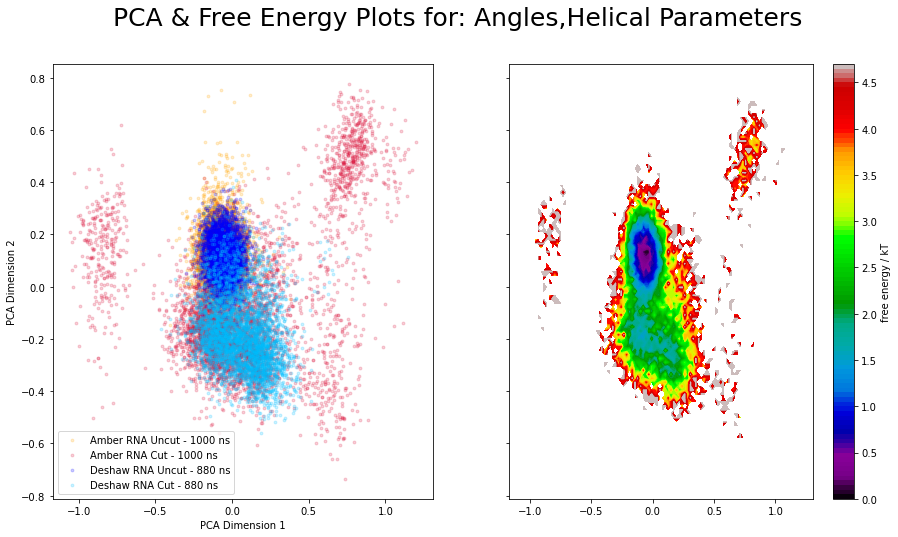

In [34]:
parameters_list = ['tilt', 'roll', 'twist']
input_array = assemble_array(Filepaths_new, parameters_list, number_of_basepairs, 12, True)

(18769, 2)


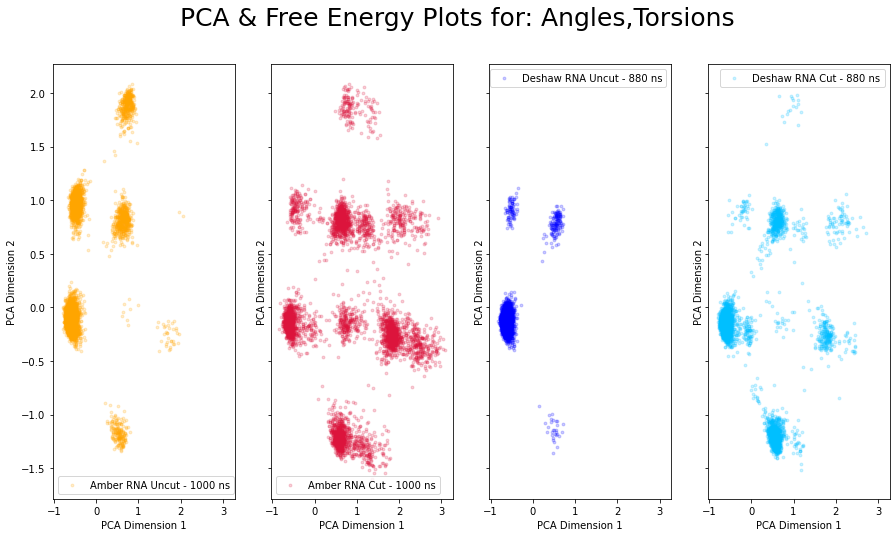

In [35]:
parameters_list = ['chiW', 'deltaW', 'gammaW', 'phaseW']
input_array = assemble_array(Filepaths_new, parameters_list, number_of_basepairs, 16, True, free_energy = False, is_seperate=True)

(18769, 2)


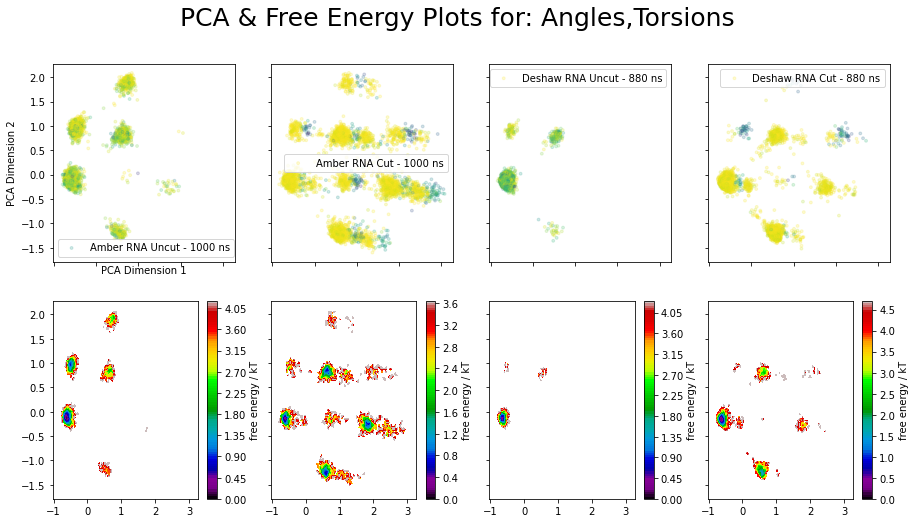

In [36]:
input_array = assemble_array(Filepaths_new, parameters_list, number_of_basepairs, 16, True, free_energy = True, is_seperate=True, default_classification = "By_Base_Pair", base_pair = 5)